Central data point in train set: ('1.000', '0.500')


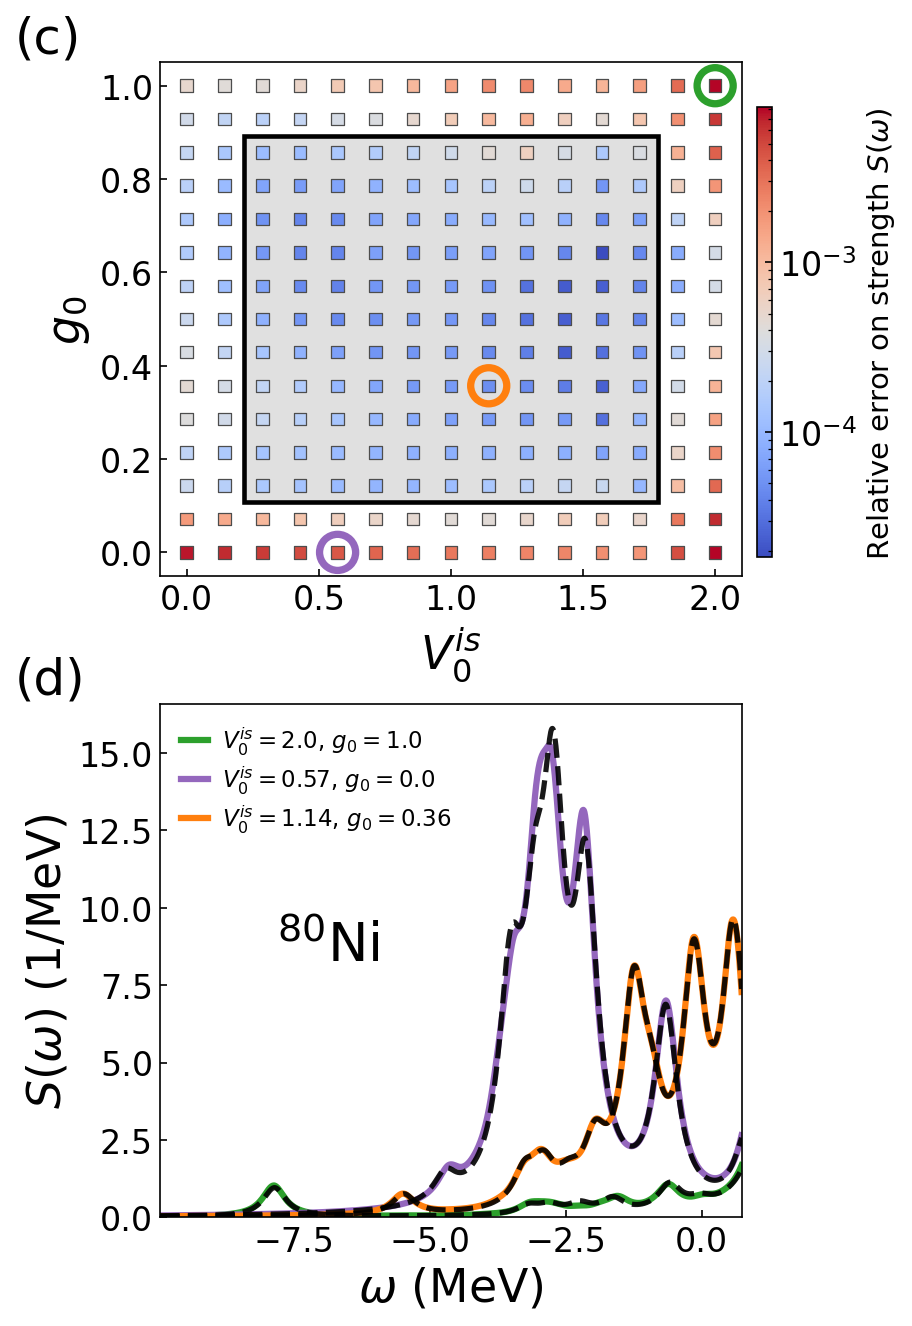

In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 31 14:39:56 2025

@author: anteravlic
"""




colors_selected=[ "#2ca02c","#9467bd","#ff7f0e"]

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat May 24 12:19:24 2025

@author: anteravlic
"""

import numpy as np
import sys
from pathlib import Path
sys.path.insert(0, str(Path("..").resolve()))
from Beta_decay import helper as beta_helper
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
import os
import re
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from numpy.polynomial.polynomial import Polynomial
import scipy.interpolate as interpolate
import matplotlib.colors as mcolors
import matplotlib.patches as patches

A = 80
Z = 28
g_A = 1.2
nucnam='Ni_80'

# Set global font size
plt.rcParams.update({'font.size': 16})
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'


fig, ax = plt.subplots(2,1 , dpi = 150, figsize = (5,10))

'''
Construction of phase space integrals
'''

poly = beta_helper.fit_phase_space(0, Z, A, 15)
coeffs = Polynomial(poly).coef


n = 13
retain = 0.9

params = np.loadtxt(f'../Beta_decay/params_best_n{n}_retain{retain}.txt')


train_set = []
with open("../Beta_decay/train_set.txt", "r") as f:
    for line in f:
        tup = tuple(map(str, line.strip().split(",")))  # Convert back to tuple of integers
        train_set.append(tup)
'''
The values of parameters should be read directly from the file name
'''
strength_dir = '../beta_decay_data_'+nucnam+'/'

# Pattern for strength files: strength_beta_alpha.out
pattern = re.compile(r'lorm_'+nucnam+'_([0-9.]+)_([0-9.]+)\.out')

formatted_alpha_values = []
formatted_beta_values = []

all_points = []

for fname in os.listdir(strength_dir):
    match = pattern.match(fname)
    if match:
        beta_val = match.group(1)
        alpha_val = match.group(2)
        all_points.append((alpha_val, beta_val))
        
        formatted_alpha_values.append(alpha_val)
        formatted_beta_values.append(beta_val)

# Example lists
alpha = formatted_alpha_values
beta = formatted_beta_values

# Combine the lists into pairs
combined = []
for i in range(len(alpha)):
    combined.append((alpha[i], beta[i]))

'''
This is added to compute a central data point
'''
# Compute centroid
combined_ar = np.array(combined, dtype = float)
centroid = combined_ar.mean(axis=0)

# Compute distances from each point to centroid
distances = np.linalg.norm(combined_ar - centroid, axis=1)

# Find index of closest point
central_index = np.argmin(distances)
central_point = tuple(combined[central_index])
print('Central data point in train set:', central_point)

Lors, HLs = beta_helper.data_table(combined, coeffs, g_A, nucnam)

opt_strength = []
HLs_opt = []


for idx in range(len(combined)):
    
    alpha = float(combined[idx][0])
    beta  = float(combined[idx][1])

    
    
    opt_D, opt_S1, opt_S2, opt_v0, fold, x1, x2, x3 = beta_helper.modified_DS(params, n)


    
    M_true = opt_D + (float(alpha)-float(central_point[0])) * opt_S1 \
        + (float(beta) - float(central_point[1])) * opt_S2
    

    eigenvalues, eigenvectors = tf.linalg.eigh(M_true)
    
    n_i = eigenvalues.shape[0]
    k_keep = int(round(retain * n_i))         # how many eigenvalues to keep
    k_keep = max(1, min(k_keep, n_i))         # safety: clamp between 1 and n
    
    left  = (n_i - k_keep) // 2               # starting index of the centered block
    right = left + k_keep                     # ending index (exclusive)
    
    eigenvalues  = eigenvalues[left:right]
    eigenvectors = eigenvectors[:, left:right]
    
    projections = tf.linalg.matvec(tf.transpose(eigenvectors), opt_v0)
    
    # Square each projection
    B = tf.square(projections)
    
    mask = tf.cast((eigenvalues > -10) & (eigenvalues < 15), dtype=tf.float64)

    # Apply the mask to zero out B where eigenvalue is negative
    B = B * mask
    

    #B = [tf.square(tf.tensordot(eigenvectors[:, i], v0_mod, axes=1)) for i in range(eigenvectors.shape[1])]
    Lor_true = tf.constant(Lors[idx][:,1], dtype=tf.float64)

    #Generate the x values
    x = tf.constant(Lors[idx][:,0], dtype=tf.float64)
    
    width = tf.sqrt(tf.square(fold) + tf.square(x1 + x2*float(alpha) + x3*float(beta)))
    

    # Use tf.map_fn to apply the give_me_Lorentzian function over the x values
    Lor = beta_helper.give_me_Lorentzian(x, eigenvalues, B, width)
    
    

    
    ''' Add half-lives to optimization as well'''

    hls = beta_helper.half_life_loss(eigenvalues, B, coeffs, g_A)
    
   
    opt_strength.append(Lor)
    
    HLs_opt.append(hls)
    








# plot the points
# '''
# Discrepancy on plot with points
# '''

# x = [float(i) for i,j in combined]
# y = [float(j) for i,j in combined]
# c = np.abs(HLs_opt - np.array(HLs))/np.array(HLs)
# im = ax[0].scatter(x, y, c = c, marker='s', cmap = 'Spectral', norm = LogNorm())
# cbar_ax = fig.add_axes([0.92, 0.55, 0.02, 0.3])  # adjust these numbers as needed
# cbar = fig.colorbar(im, cax=cbar_ax)
# cbar.set_label(r"Relative error on $T_{1/2}$", fontsize=14)

'''
Discrepancy on plot with points
Replace this whole block with the code below to show the relative L2 error
on the strength function instead of the half-life error.
'''

# Coordinates to plot
x_vals = [float(i) for i, j in combined]   # V_0^{is}
y_vals = [float(j) for i, j in combined]   # g_0

# Compute relative L2 error: ∫(Ŝ−S)^2 dE / ∫S^2 dE for each (alpha, beta)
rel_L2 = np.empty(len(combined), dtype=float)

for k, (Lor_hat_k, Lor_true_pair_k) in enumerate(zip(opt_strength, Lors)):
    # True data: columns [E, S_true]
    E = np.asarray(Lor_true_pair_k[:, 0], dtype=np.float64)
    S_true = np.asarray(Lor_true_pair_k[:, 1], dtype=np.float64)

    # Emulator result on the same grid
    S_hat = np.asarray(Lor_hat_k, dtype=np.float64)

    # Integrals (trapezoidal rule)
    num = np.trapz((S_hat - S_true)**2, E)
    den = np.trapz(S_true**2, E)
    rel_L2[k] = num / den if den > 0 else np.nan

# Prepare for LogNorm: remove NaNs and clip tiny values
mask = np.isfinite(rel_L2)
c_vals = np.clip(rel_L2[mask], 1e-16, None)
x_plot = np.asarray(x_vals)[mask]
y_plot = np.asarray(y_vals)[mask]

# im = ax[0].scatter(x_plot, y_plot, c=c_vals, marker='s', cmap='Spectral_r', norm=LogNorm())
# im = ax[0].scatter(x_plot, y_plot, c=c_vals, marker='s', cmap='turbo', norm=LogNorm())

im = ax[0].scatter(x_plot, y_plot, c=c_vals, marker='s',
                   cmap='coolwarm', norm=LogNorm(),
                   edgecolors='0.3', linewidths=0.6)

cbar_ax = fig.add_axes([0.92, 0.55, 0.02, 0.3])  # keep same placement
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"Relative error on strength $S(\omega)$", fontsize=14)

# Add index numbers
# for idx, (xi, yi) in enumerate(zip(x, y)):
#     plt.text(xi, yi, str(idx), ha='center', va='center', fontsize=8, color='black')

# Convert train_set to float arrays for min/max
train_alpha = [float(a) for (a, b) in train_set]
train_beta  = [float(b) for (a, b) in train_set]

alpha_min = min(train_alpha)
alpha_max = max(train_alpha)
beta_min  = min(train_beta)
beta_max  = max(train_beta)




# # Add rectangle to ax_grid
# train_rect = patches.Rectangle(
#     (alpha_min, beta_min),
#     alpha_max - alpha_min,
#     beta_max - beta_min,
#     linewidth=1.5,
#     edgecolor='black',
#     facecolor='none'
# )
# ax[0].add_patch(train_rect)





# --- shaded training region on the (x=d_TV, y=b_TV) panel ---

# --- pad the training box outward by ~half a grid step ---
# use the actual scatter grid to estimate spacing
ux = np.unique(np.round(np.asarray(x_vals, float), 6))
uy = np.unique(np.round(np.asarray(y_vals, float), 6))
dx = np.min(np.diff(ux)) if ux.size > 1 else 0.0
dy = np.min(np.diff(uy)) if uy.size > 1 else 0.0
pad_x = 0.5 * dx
pad_y = 0.5 * dy

xmin = alpha_min - pad_x
xmax = alpha_max + pad_x
ymin = beta_min  - pad_y
ymax = beta_max  + pad_y

# (optional) clamp to current axes limits so the patch stays in view
x_lo, x_hi = ax[0].get_xlim()
y_lo, y_hi = ax[0].get_ylim()
xmin = max(xmin, x_lo); xmax = min(xmax, x_hi)
ymin = max(ymin, y_lo); ymax = min(ymax, y_hi)

# draw fill (translucent) + solid black edge
face_rgba = mcolors.to_rgba('0.6', 0.30)     # grey, 20% opacity
fill = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                         facecolor=face_rgba, edgecolor='none', zorder=0.5)
edge = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                         facecolor='none', edgecolor='k', linewidth=2.2, zorder=0.6)
ax[0].add_patch(fill)
ax[0].add_patch(edge)













ax[0].set_ylabel('$g_0$', size = 22)
ax[0].set_xlabel('$V_0^{is}$', size = 22)


'''
This here plots the Lorentzians
'''
idx =  [183, 66, 124]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(len(idx)):
    
    alpha = float(combined[idx[i]][0])
    beta  = float(combined[idx[i]][1])
    

    ax[0].scatter(alpha, beta, ec = colors_selected[i],
                  # colors[i], 
                  s = 300, fc = 'none',linewidths=3.5)
    
    
    
    opt_D, opt_S1, opt_S2, opt_v0, fold, x1, x2, x3 = beta_helper.modified_DS(params, n)
    
    
    
    M_true = opt_D + (float(alpha)-float(central_point[0])) * opt_S1 \
        + (float(beta) - float(central_point[1])) * opt_S2
    
    
    eigenvalues, eigenvectors = tf.linalg.eigh(M_true)
    
    n_i = eigenvalues.shape[0]
    k_keep = int(round(retain * n_i))         # how many eigenvalues to keep
    k_keep = max(1, min(k_keep, n_i))         # safety: clamp between 1 and n
    
    left  = (n_i - k_keep) // 2               # starting index of the centered block
    right = left + k_keep                     # ending index (exclusive)
    
    eigenvalues  = eigenvalues[left:right]
    eigenvectors = eigenvectors[:, left:right]
    
    projections = tf.linalg.matvec(tf.transpose(eigenvectors), opt_v0)
    
    # Square each projection
    B = tf.square(projections)
    
    mask = tf.cast((eigenvalues > -10) & (eigenvalues < 15), dtype=tf.float64)
    
    # Apply the mask to zero out B where eigenvalue is negative
    B = B * mask
    
    
    #B = [tf.square(tf.tensordot(eigenvectors[:, i], v0_mod, axes=1)) for i in range(eigenvectors.shape[1])]
    Lor_true = tf.constant(Lors[idx[i]][:,1], dtype=tf.float64)
    
    #Generate the x values
    x = tf.constant(Lors[idx[i]][:,0], dtype=tf.float64)
    
    width = tf.sqrt(tf.square(fold) + tf.square(x1 + x2*float(alpha) + x3*float(beta)))
    
    
    # Use tf.map_fn to apply the give_me_Lorentzian function over the x values
    Lor = beta_helper.give_me_Lorentzian(x, eigenvalues, B, width)
    
    #ax[1].plot(x, Lor, color = 'black', ls = '--')
    f1 = interpolate.interp1d(x, Lor, kind = 'cubic')
    #ax[1].plot(x, Lor_true)
    f2 = interpolate.interp1d(x, Lor_true, kind = 'cubic')
    
    xnew = np.linspace(np.min(x), np.max(x), 1000)
    ax[1].plot(xnew, f1(xnew), color = 'black', ls = '--', lw = 2.5, alpha = 0.9, zorder=99)
    # ax[1].plot(xnew, f2(xnew), lw = 3, label = '$g_0 = $'+str(round(beta,2))+', $V_0^{is} = $'+str(round(alpha,2)),
    #            color=colors_selected[i]
    #           )
    ax[1].plot(xnew, f2(xnew), lw = 3, label = '$V_0^{is} = $'+str(round(alpha,2))+', $g_0 = $'+str(round(beta,2)) ,
               color=colors_selected[i]
              )
    
ax[1].set_ylim(0)
ax[1].set_xlim(np.min(x), np.max(x))
# ax[1].legend(frameon = False, fontsize = 10)
leg = ax[1].legend(
    frameon=False, fontsize=11,
    loc='upper left',           # anchor corner of the legend box
    bbox_to_anchor=(0, 1.0), # move box a bit to the right of the axes
    handlelength=1.2,           # shorter line samples
    handletextpad=0.6,          # space between line and text
    labelspacing=0.3            # vertical spacing between entries
)


ax[1].set_xlabel(r'$\omega$ (MeV)', size = 22)
ax[1].set_ylabel('$S(\omega)$ (1/MeV)', size = 22)


ax[0].annotate('(c)', (-0.25, 1.02), xycoords='axes fraction', size = 24)
ax[1].annotate('(d)', (-0.25, 1.02), xycoords='axes fraction', size = 24)
ax[1].annotate('${}^{80}$Ni', (0.2, 0.5), xycoords='axes fraction', size = 26)

plt.subplots_adjust(hspace = 0.25)

plt.savefig('NiPerformance.pdf', bbox_inches='tight')






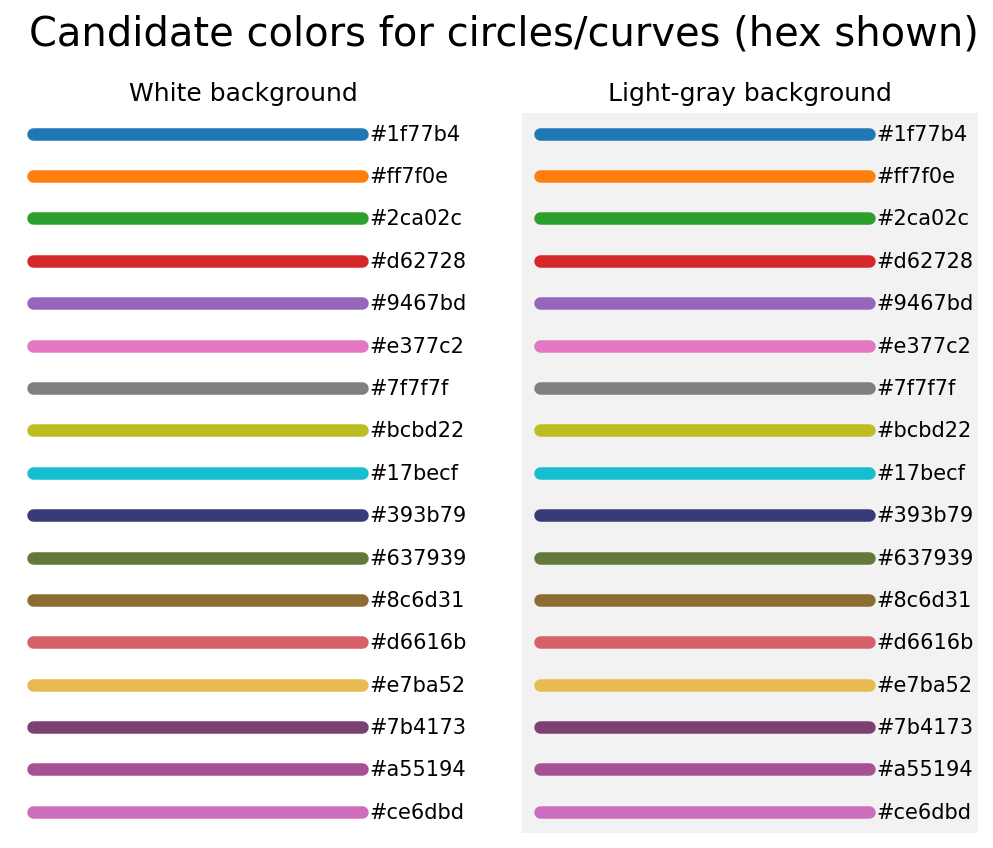

In [2]:


# #Some colors that Pablo likes:
colors = [
    "#1f77b4", # Vivid blue
    "#ff7f0e", # Bright orange
    "#2ca02c", # Rich green
    "#d62728", # Strong red
    "#9467bd", # Deep purple
    # "#8c564b", # Brownish-pink
    "#e377c2", # Pink
    "#7f7f7f", # Medium gray
    "#bcbd22", # Lime green
    "#17becf", # Cyan
    "#393b79", # Dark blue
    "#637939", # Olive green
    "#8c6d31", # Bronze
    # "#843c39", # Dark red
    # "#ad494a", # Reddish brown
    "#d6616b", # Soft red
    "#e7ba52", # Golden yellow
    "#7b4173", # Dark purple
    "#a55194", # Mauve
    "#ce6dbd", # Light purple
]


N = len(colors)
x0, x1 = 0.05, 0.95   # horizontal span of each line

fig, axes = plt.subplots(1, 2, figsize=(7, 6), dpi=150, sharey=True)
axes[0].set_title("White background", fontsize=12)
axes[1].set_title("Light-gray background", fontsize=12)
axes[1].set_facecolor('#f2f2f2')

for ax in axes:
    for i, c in enumerate(colors[::-1], start=1):  # top to bottom
        y = i
        ax.plot([x0, x1], [y, y], lw=6, color=c, solid_capstyle='round')
        ax.text(x1 + 0.02, y, f"{c}", va='center', ha='left', fontsize=10)

    ax.set_xlim(0, 1.25)
    ax.set_ylim(0.5, N + 0.5)
    ax.set_xticks([]); ax.set_yticks([])
    ax.spines[['top','right','bottom','left']].set_visible(False)

fig.suptitle("Candidate colors for circles/curves (hex shown)", y=0.95)
fig.tight_layout()

plt.show()
